Importing

In [1]:
from __future__ import print_function

import numpy as np
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp2d
from scipy.spatial.distance import directed_hausdorff
from scipy.cluster import hierarchy
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from seaborn import clustermap
import sklearn.cluster

import librosa
import librosa.segment
import librosa.display

from sklearn.metrics.pairwise import pairwise_distances

import glob
import os

import random

Function to generate visually distinct colors for line plotting

In [2]:
def colors(n):
  #ret = []
  r = int(random.random() * 256)
  g = int(random.random() * 256)
  b = int(random.random() * 256)
  step = 256 / n
  for i in range(n):
    r += step
    g += step
    b += step
    r = int(r) % 256
    g = int(g) % 256
    b = int(b) % 256
    #ret.append((r,g,b)) 
  return (r/255,g/255,b/255)

Reading files and keeping a list of their directories

In [3]:
all_dirs = []
all_locations = []
directory = './Mini_Test_Dataset' #change directory here
directory_len = len(directory)
for root, dirs, files in os.walk(directory):
        for name in files:
            if (('.wav' in name) or ('.aif' in name)):
                filedir = os.path.join(root, name)
                all_dirs.append(filedir)
                #Geolocation
                if 'Music from Yemen Arabia	Yemen' in filedir:
                    all_locations.append('Yemen')
                elif 'Traditional' in filedir:
                    all_locations.append('Yemen')
                elif 'U-Cef' in filedir:
                    all_locations.append('Morocco')
                elif 'The art of the old Egyptian Qanun' in filedir:
                    all_locations.append('Egypt')
                elif 'Dariush Talai' in filedir:
                    all_locations.append('Iran')
                elif 'Gene Coleman' in filedir:
                    all_locations.append('Lebanon')
                elif 'Marie Keyrouz_ Ensemble De La Paix' in filedir:
                    all_locations.append('Lebanon')
                elif 'The Music of Mohamed Abdel Wahab' in filedir:
                    all_locations.append('Egypt')
                elif 'Mansour Zayed' in filedir:
                    all_locations.append('UAE')
                elif 'Music of the Sultans, Sufis & Seraglio - Vol. 4 _ Ottoman Suite' in filedir:
                    all_locations.append('Turkey')
                elif 'Kurdish Music' in filedir:
                    all_locations.append('Kurdistan')
                elif 'Mawja' in filedir:
                    all_locations.append('Lebanon')
                elif 'Enty Helm' in filedir:
                    all_locations.append('Kuwait')
                else:
                    all_locations.append('East Africa')


print('Read ' + str(len(all_dirs)) + ' files')
print(all_dirs)
print(all_locations)

Read 5 files
['./Mini_Test_Dataset/Junju Meya.aif', './Mini_Test_Dataset/Rahimu Inua Ngao.aif', './Mini_Test_Dataset/03 Dastgah-e Crgah - Daramad-e sevvom.wav', './Mini_Test_Dataset/05 Yuruk sema i (Itri).wav', './Mini_Test_Dataset/04 Ibnil Balad.wav']
['East Africa', 'East Africa', 'East Africa', 'East Africa', 'East Africa']


Calculating the Laplacian (Check https://librosa.github.io/librosa/auto_examples/plot_segmentation.html)

In [12]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
all_A = []
for i in range(len(all_dirs)):
    y, sr = librosa.load(all_dirs[i])
    #print('Loaded ' + str(all_dirs[i]))
    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                            ref=np.max)
    #print('Spectrogram of ' + str(all_dirs[i]))
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    #print('Beat tracking ' + str(all_dirs[i]))
    Csync = librosa.util.sync(C, beats, aggregate=np.median)
    #print('Syncing ' + str(all_dirs[i]))
    Cstack = librosa.feature.stack_memory(Csync, 4)
    #print('Stack memory ' + str(all_dirs[i]))
    
    R = librosa.segment.recurrence_matrix(Cstack, width=3, mode='affinity',
                                      sym=True)
    #print('Recurrence matrix ' + str(all_dirs[i]))
    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    #print('Timelag filter ' + str(all_dirs[i]))
    Rf = librosa.segment.path_enhance(Rf, 15)
    #print('Path enhance ' + str(all_dirs[i]))
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    Msync = librosa.util.sync(mfcc, beats)

    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)

    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)
    #print('Sequence matrix ' + str(all_dirs[i]))
    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)

    print(deg_path.shape)
    print(deg_rec.shape)
    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

    A = mu * Rf + (1 - mu) * R_path
    all_A.append(A)
    #print('Balance combination ' + str(all_dirs[i]))
    
    #L = scipy.sparse.csgraph.laplacian(A, normed=True)
    #print('Laplacian of ' + str(all_dirs[i]))
    
    print('Completed ' + str(all_dirs[i]))
    
print("Completed")

(457,)
(457,)
Completed ./Mini_Test_Dataset/Junju Meya.aif
(575,)
(575,)
Completed ./Mini_Test_Dataset/Rahimu Inua Ngao.aif
(116,)
(116,)
Completed ./Mini_Test_Dataset/03 Dastgah-e Crgah - Daramad-e sevvom.wav
(387,)
(387,)
Completed ./Mini_Test_Dataset/05 Yuruk sema i (Itri).wav
(424,)
(424,)
Completed ./Mini_Test_Dataset/04 Ibnil Balad.wav
Completed


Downsampling balanced combination

Computed all interpolation functions
Resampled balanced combinations
Showing first balanced combination...


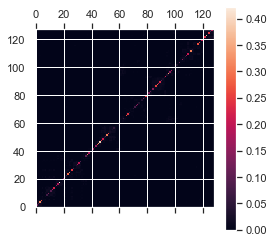

In [138]:
#Size to which it will down/upsample //uncomment the code below if you want to downsample everything to size of smallest matrix
min_size = 128

# #Finding minimum array
# min_size = 1000000
# for i in range(len(all_A)):
#     #print(all_L[i].shape[0])
#     if (all_A[i].shape[0])<min_size:
#         min_size = all_A[i].shape[0]

#Interpolation functions
all_f = []
for i in range(len(all_A)):
    #f = interp2d(np.arange(0, all_L[i].shape[0], 1), np.arange(0, all_L[i].shape[0], 1), all_L[i].flatten(), kind='linear')
    Xindex = np.linspace(0, 1, num=all_A[i].shape[0])
    f = interp2d(Xindex, Xindex, all_A[i].flatten(), kind='linear')
    all_f.append(f)
print('Computed all interpolation functions')

all_A_ds = [] #all downsampled Laplacians
for i in range(len(all_A)):
    Xindex_ds = np.linspace(0, 1, num=min_size)
    all_A_ds.append(np.reshape(all_f[i](Xindex_ds, Xindex_ds), (min_size, min_size)))
print('Resampled balanced combinations')

print('Showing first balanced combination...')
plt.matshow(all_A_ds[0], origin='lower')
plt.colorbar()
plt.show()

Calculating the Laplacians from the combined graphs

In [47]:
all_L = []
all_L_ds = []

for i in range(len(all_A)):
    all_L.append(scipy.sparse.csgraph.laplacian(all_A[i], normed=True))
    all_L_ds.append(scipy.sparse.csgraph.laplacian(all_A_ds[i], normed=True))
    
print('Completed')

Completed


Calculating evals and distance matrix from structural components both from original and downsampled Laplacian (for testing purposes, to check if downsampling was done correctly)

In [90]:
all_dist = []
all_evals = []
all_dist_ds = []
all_evals_ds = []

#For original combined graphs
for i in range(len(all_A)):
    evals, evecs = scipy.linalg.eigh(all_L[i])
    
    all_evals.append(evals)
    
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    
    k = 10 #Change component number here

    X = evecs[:, :k] / Cnorm[:, k-1:k]
    
    #distance = squareform(pdist(X, lambda a,b: np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)))
    distance = squareform(pdist(X, metric='euclidean'))
    
    all_dist.append(distance)
    
    print('Completed for ' + str(all_dirs[i]))

#For downsampled combined graphs
for i in range(len(all_L_ds)):
    evals, evecs = scipy.linalg.eigh(all_L_ds[i])
    
    all_evals_ds.append(evals)
    
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    
    k = 10 #Change component number here

    X = evecs[:, :k] / Cnorm[:, k-1:k]
    
    #distance = squareform(pdist(X, lambda a,b: np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)))
    distance = squareform(pdist(X, metric='euclidean'))
    
    all_dist_ds.append(distance)
    
    print('Completed for ' + str(all_dirs[i]))

print('Completed')
    

Completed for ./Dataset/Mawja/Studio One/01 S 1.1.wav
Completed for ./Dataset/Mawja/Studio One/06 S 1.6.wav
Completed for ./Dataset/Mawja/Studio One/03 S 1.3.wav
Completed for ./Dataset/Mawja/Studio One/05 S 1.5.wav
Completed for ./Dataset/Mawja/Studio One/04 S 1.4.wav
Completed for ./Dataset/Mawja/Studio One/02 S 1.2.wav
Completed for ./Dataset/U-Cef/Halalium/01 The Moorish Matador.wav
Completed for ./Dataset/U-Cef/Halalium/06 Halal Monk.wav
Completed for ./Dataset/U-Cef/Halalium/12 Gnasaid.wav
Completed for ./Dataset/U-Cef/Halalium/09 DJ Faisal On The 1 'n' 2.wav
Completed for ./Dataset/U-Cef/Halalium/03 Tagazoot.wav
Completed for ./Dataset/U-Cef/Halalium/04 Hijra.wav
Completed for ./Dataset/U-Cef/Halalium/10 Maghreb (Ça passe ou ça kasse).wav
Completed for ./Dataset/U-Cef/Halalium/11 Sonic Moor.wav
Completed for ./Dataset/U-Cef/Halalium/02 Aalash Kwawna.wav
Completed for ./Dataset/U-Cef/Halalium/07 Marrakech Raggamuffins.wav
Completed for ./Dataset/U-Cef/Halalium/08 Bouhala.wav
Co

Plotting all distance matrices for original and downsampled Laplacians

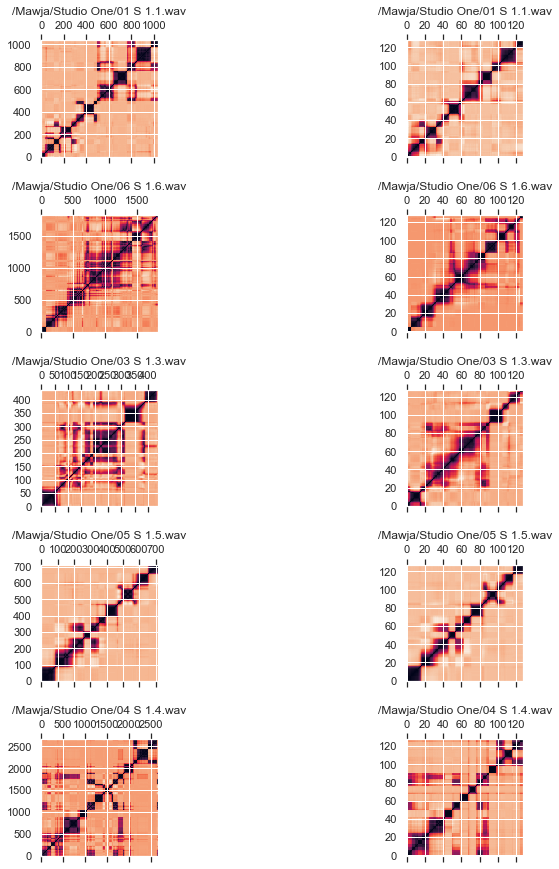

In [100]:
fig, axs = plt.subplots(5, 2, figsize=(12, 15))
for i in range(5):
    axs[i, 0].matshow(all_dist[i], origin='lower')
    axs[i, 0].set_title(all_dirs[i][directory_len:], y=1)
    axs[i, 1].matshow(all_dist_ds[i], origin='lower')
    axs[i, 1].set_title(all_dirs[i][directory_len:], y=1)
plt.subplots_adjust(hspace=0.5)
plt.show()     

Plotting first 30 eigenvalues over time of original laplacians

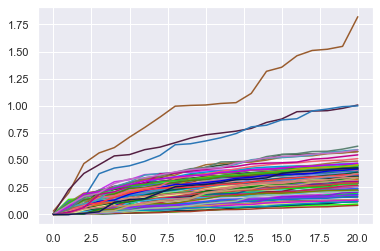

In [101]:
# no_evals = all_evals_ds[0].size
# all_evals_ds_20 = []
# for i in range(len(all_evals_ds)):
#     all_evals_ds_20.append(all_evals_ds[i][:20])
# for i in range(len(all_evals_ds_20)):
#     plt.plot(np.arange(min_size), all_evals_ds_20[i], color=colors(i+1))

no_evalplot = 21
all_evals_plot = []
for i in range(len(all_evals)):
    all_evals_plot.append(all_evals[i][:no_evalplot])
for i in range(len(all_evals_plot)):
    plt.plot(np.arange(no_evalplot), all_evals_plot[i], color=colors(i+1))

t-SNE to 2 dimension from feature vector of 30 eigenvalues per song

In [103]:
from sklearn.manifold import TSNE
X2 = TSNE(n_components=2).fit_transform(all_evals_plot)

Plotting t-SNE graph, each dot is a song represented by its first 30 eigenvalues

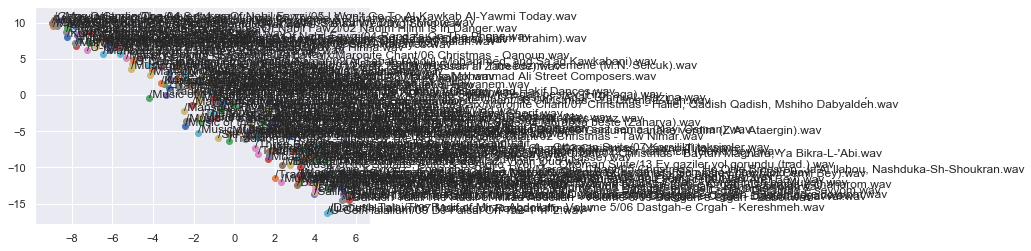

In [104]:
#matplotib
fig, ax = plt.subplots()
for i in range(len(all_evals)):
    plt.scatter(X2[i][0], X2[i][1])
    
for i in range(len(all_dirs)):
    ax.annotate(all_dirs[i][directory_len:], (X2[i][0], X2[i][1]))

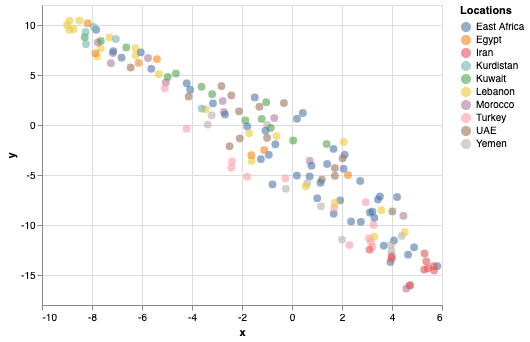

In [105]:
#altair
import vega
import altair as alt
import pandas as pd

x_axis = []
y_axis = []

for i in range(len(X2)):
    x_axis.append(X2[i][0])
    y_axis.append(X2[i][1])
    
df1 = pd.DataFrame({'x': np.asarray(x_axis), 'y': np.asarray(y_axis), 'path': np.asarray(all_dirs), 'filename': np.asarray(all_dirs), 'Locations': np.asarray(all_locations)})
viz1 = alt.Chart(df1).mark_circle(opacity=0.6, size=60).encode(x='x', y='y', href='path', tooltip='filename', color='Locations').interactive()
display(viz1)

t-SNE to 2 dimensions of distance matrix build from k first eigenvectors of Laplacian

In [106]:
all_sim = []
#Flatten
for i in range(len(all_dist)):
    all_sim.append(all_dist_ds[i].flatten())

#t-SNE
X2 = TSNE(n_components=2).fit_transform(all_sim)

Plotting t-SNE graph, each dot is a song represented by its distance matrix built from the first k eigenvectors of the Laplacian

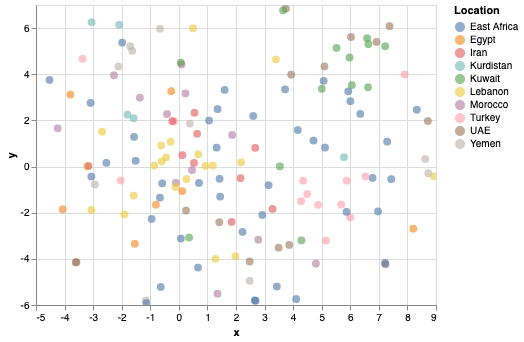

In [110]:
x_axis_sim = []
y_axis_sim = []
for i in range(len(X2)):
    x_axis_sim.append(X2[i][0])
    y_axis_sim.append(X2[i][1])
    
df2 = pd.DataFrame({'x': np.asarray(x_axis_sim), 'y': np.asarray(y_axis_sim), 'path': np.asarray(all_dirs), 'filename': np.asarray(all_dirs), 'Location': np.asarray(all_locations)})
viz2 = alt.Chart(df2).mark_circle(opacity=0.6, size=60).encode(x='x', y='y', href='path', tooltip='filename', color='Location').interactive()
display(viz2)

Creating sets with multiple instances of k eigenvectors of the Laplacian per song (using the already downsampled Laplacians)

In [120]:
all_dist_ds_k = []
for i in range(len(all_L_ds)):
    evals, evecs = scipy.linalg.eigh(all_L_ds[i])
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    
    dist_ds_k = []
    for k in range(2, 10): #change range here (min value 2)
        X = evecs[:, :k] / Cnorm[:, k-1:k]
        distance = squareform(pdist(X, metric='euclidean'))
        dist_ds_k.append(distance)
    
    all_dist_ds_k.append(dist_ds_k)
    print('Completed for ' + str(all_dirs[i]))
print('Completed')

print(np.asarray(all_dist_ds_k).shape)

Completed for ./Dataset/Mawja/Studio One/01 S 1.1.wav
Completed for ./Dataset/Mawja/Studio One/06 S 1.6.wav
Completed for ./Dataset/Mawja/Studio One/03 S 1.3.wav
Completed for ./Dataset/Mawja/Studio One/05 S 1.5.wav
Completed for ./Dataset/Mawja/Studio One/04 S 1.4.wav
Completed for ./Dataset/Mawja/Studio One/02 S 1.2.wav
Completed for ./Dataset/U-Cef/Halalium/01 The Moorish Matador.wav
Completed for ./Dataset/U-Cef/Halalium/06 Halal Monk.wav
Completed for ./Dataset/U-Cef/Halalium/12 Gnasaid.wav
Completed for ./Dataset/U-Cef/Halalium/09 DJ Faisal On The 1 'n' 2.wav
Completed for ./Dataset/U-Cef/Halalium/03 Tagazoot.wav
Completed for ./Dataset/U-Cef/Halalium/04 Hijra.wav
Completed for ./Dataset/U-Cef/Halalium/10 Maghreb (Ça passe ou ça kasse).wav
Completed for ./Dataset/U-Cef/Halalium/11 Sonic Moor.wav
Completed for ./Dataset/U-Cef/Halalium/02 Aalash Kwawna.wav
Completed for ./Dataset/U-Cef/Halalium/07 Marrakech Raggamuffins.wav
Completed for ./Dataset/U-Cef/Halalium/08 Bouhala.wav
Co

Create self-similarity matrix using each set of k-component eigenvectors for each song by calculating the directed Hausdorff distance between each set combination

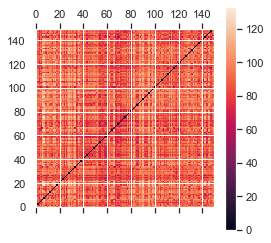

In [121]:
for i in range(len(all_dist_ds_k)): #flattening the matrices
    for j in range(len(all_dist_ds_k[i])):
        all_dist_ds_k[i][j] = all_dist_ds_k[i][j].flatten()
    
SM = np.zeros((len(all_dirs), len(all_dirs)))
              
for i in range(len(all_dirs)):
    for j in range(len(all_dirs)):
        SM[i][j] = (directed_hausdorff(all_dist_ds_k[i], all_dist_ds_k[j]))[0]
        
plt.matshow(SM, origin='lower')
plt.colorbar()
plt.show()

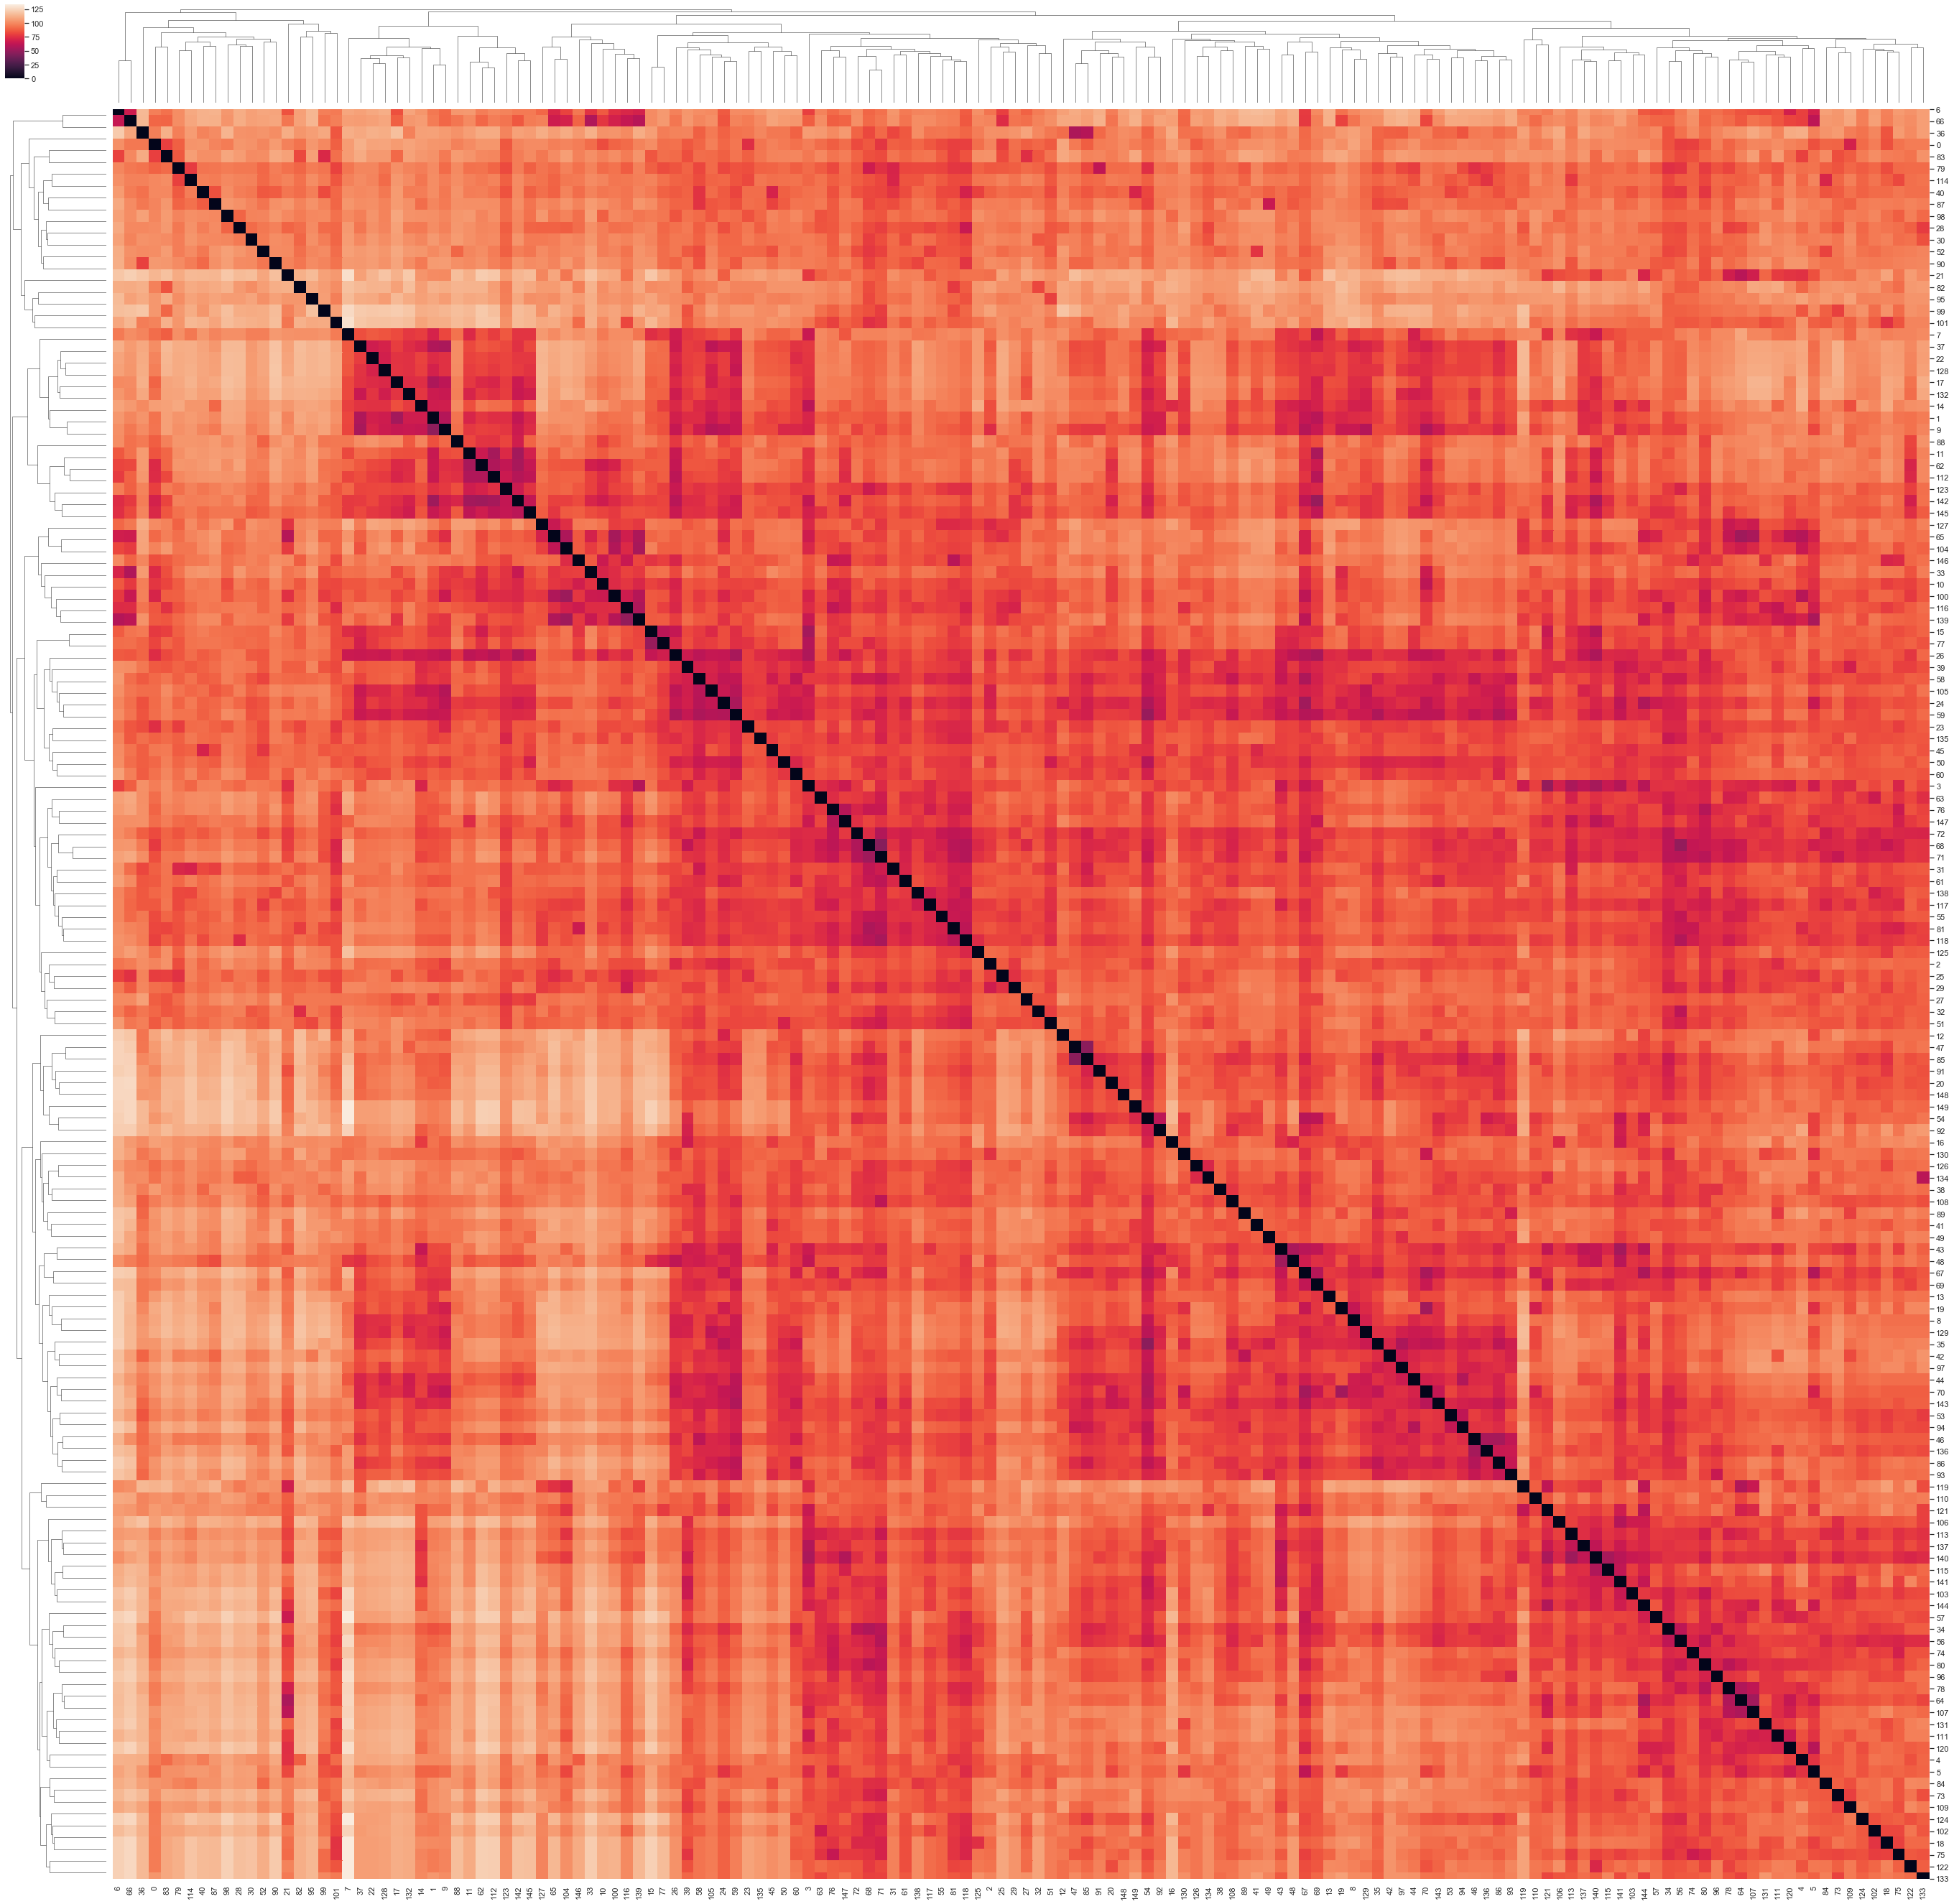

In [125]:
linkage = hierarchy.linkage(SM, method='average')
g = clustermap(SM, row_linkage=linkage, col_linkage=linkage, figsize=(48, 48))

./Dataset/Music of the Sultans, Sufis & Seraglio - Vol. 4 _ Ottoman Suite/11 Yine bezm-i cemene (M.N. Selcuk).wav


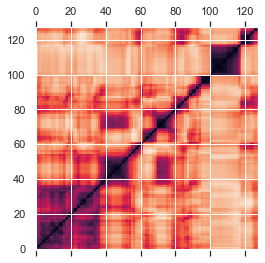

In [126]:
print(all_dirs[78])
#pandas: row number and associated color from locations

plt.matshow(all_dist_ds[78], origin='lower')


./Dataset/Traditional/Yemen - Music Of The North/05 Aghani Atifi.wav


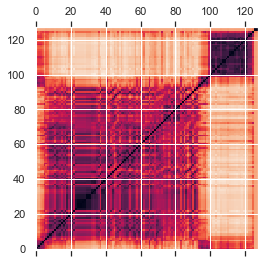

In [136]:
plt.matshow(all_dist_ds[64], origin='lower')
print(all_dirs[64])

./Dataset/Music from Yemen Arabia/Samar/01 Leish Teguib (Hassan al Zabeede).wav


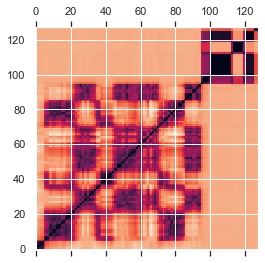

In [137]:
plt.matshow(all_dist_ds[21], origin='lower')
print(all_dirs[21])

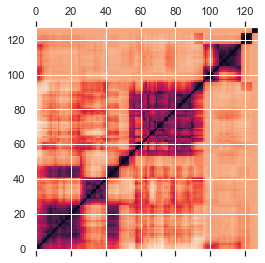

In [128]:
plt.matshow(all_dist_ds[107], origin='lower')

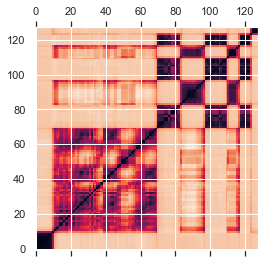

In [129]:
plt.matshow(all_dist_ds[110], origin='lower')

./Dataset/U-Cef/Halalium/09 DJ Faisal On The 1 'n' 2.wav


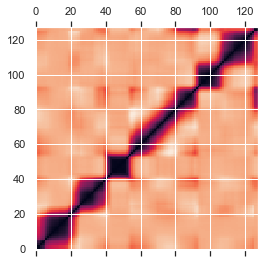

In [135]:
plt.matshow(all_dist_ds[9], origin='lower')
print(all_dirs[9])

./Dataset/Music from Yemen Arabia/Samar/01 Leish Teguib (Hassan al Zabeede).wav


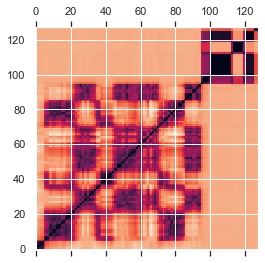

In [134]:

print(all_dirs[21])
plt.matshow(all_dist_ds[21], origin='lower')

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


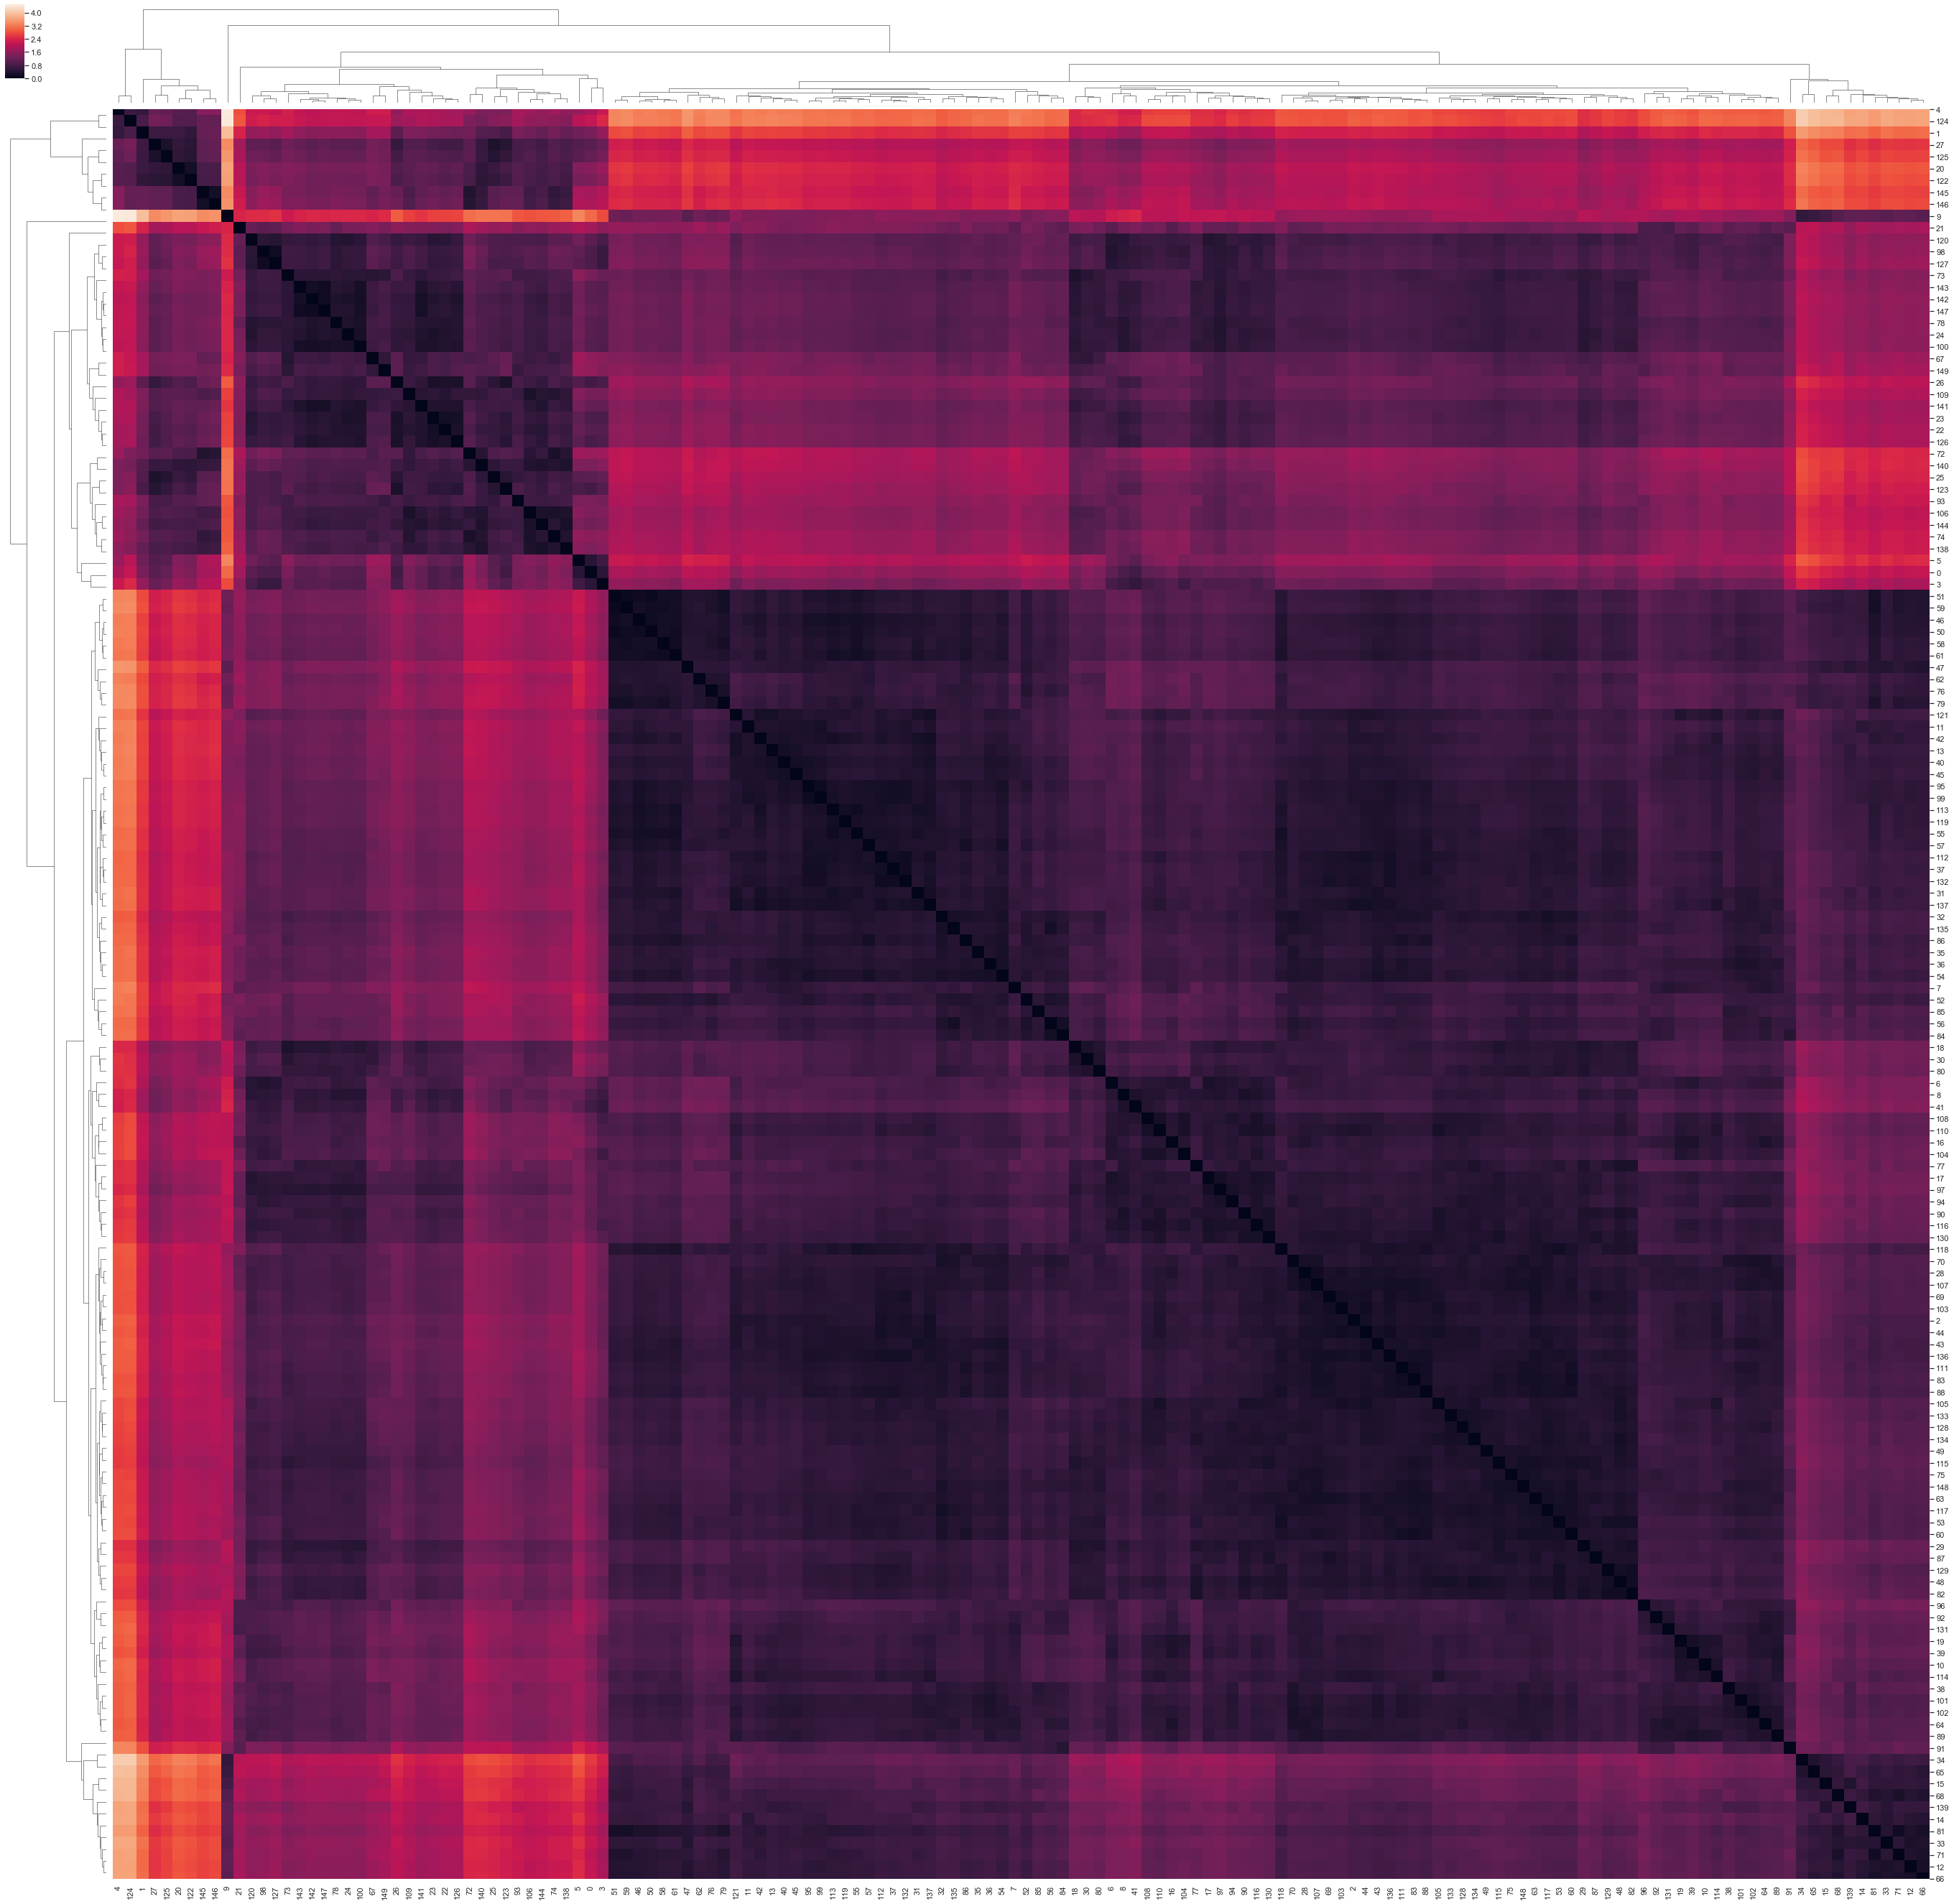

In [131]:
distance_eval = squareform(pdist(np.asarray(all_evals_ds), metric='euclidean'))
linkage_eval = hierarchy.linkage(distance_eval, method='average')
h = clustermap(distance_eval, row_linkage=linkage_eval, col_linkage=linkage_eval, figsize=(48, 48))